In [1]:
#"Hayvan Tanıma Git Repostory Oluşturuldu"

In [2]:
import os
from tensorflow.python.keras.optimizers import SGD

import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, History
import tensorflow as tf
from time import time
import numpy as np
import pandas as pd

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # UYARILARI KAPATMA


/home/ufuk/anaconda3/envs/tensor/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ufuk/anaconda3/envs/tensor/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ufuk/anaconda3/envs/tensor/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ufuk/anaconda3/envs/tensor/lib/python3.7/site-

In [3]:
#print(os.listdir("./images/train"))
SIZE = 224
EPOCH = 50
BATCH = 32
train_directory = "images/train/"
valid_directory = "images/valid/"
test_directory = "images/test/"

data_aug = ImageDataGenerator(rotation_range=40,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              shear_range=0.2,
                              rescale=1. / 255,
                              zoom_range=0.2,
                              horizontal_flip=True,
                              fill_mode="nearest",
                              validation_split=0.25
                              )
test_aug = ImageDataGenerator(rescale = 1./255)
#Max batch size= available GPU memory bytes / 4 / (size of tensors + trainable parameters)
train_generator = data_aug.flow_from_directory(directory=train_directory,
                                               batch_size=BATCH,
                                               shuffle=True,
                                               class_mode="categorical",
                                               color_mode="rgb",
                                               target_size=(SIZE, SIZE),
                                               interpolation="nearest",
                                               subset="training",
                                               seed=42
                                               )
validation_generator = data_aug.flow_from_directory(directory=train_directory,
                                                    batch_size=BATCH,
                                                    shuffle=True,
                                                    class_mode="categorical",
                                                    color_mode="rgb",
                                                    target_size=(SIZE, SIZE),
                                                    interpolation="nearest",
                                                    subset="validation",
                                                    seed=42
                                                    )
test_generator = test_aug.flow_from_directory(directory=test_directory,
                                              batch_size=1,
                                              shuffle=False,
                                              class_mode="categorical",
                                              target_size=(SIZE, SIZE)
                                              )




Found 4987 images belonging to 37 classes.
Found 1626 images belonging to 37 classes.
Found 777 images belonging to 37 classes.


In [4]:
print(train_generator.class_indices)

{'Abyssinian': 0, 'Bengal': 1, 'Birman': 2, 'Bombay': 3, 'British_Shorthair': 4, 'Egyptian_Mau': 5, 'Maine_Coon': 6, 'Persian': 7, 'Ragdoll': 8, 'Russian_Blue': 9, 'Siamese': 10, 'Sphynx': 11, 'american_bulldog': 12, 'american_pit_bull_terrier': 13, 'basset_hound': 14, 'beagle': 15, 'boxer': 16, 'chihuahua': 17, 'english_cocker_spaniel': 18, 'english_setter': 19, 'german_shorthaired': 20, 'great_pyrenees': 21, 'havanese': 22, 'japanese_chin': 23, 'keeshond': 24, 'leonberger': 25, 'miniature_pinscher': 26, 'newfoundland': 27, 'pomeranian': 28, 'pug': 29, 'saint_bernard': 30, 'samoyed': 31, 'scottish_terrier': 32, 'shiba_inu': 33, 'staffordshire_bull_terrier': 34, 'wheaten_terrier': 35, 'yorkshire_terrier': 36}


In [5]:
tf.keras.backend.clear_session()

In [6]:

vgg16_model = VGG16(pooling="avg", input_shape=(224, 224, 3), weights="imagenet", include_top=False)
for layer in vgg16_model.layers:
    layer.trainable = False
VGG = tf.keras.Sequential([
    vgg16_model,
    Flatten(),
    Dense(units=4096, activation="relu"),
    Dropout(0.1),
    Dense(units=1024, activation="relu"),
    Dropout(0.1),
    Dense(units=37, activation="softmax"),
    Dropout(0.1)
])
opt = SGD(lr=0.01, momentum=0.9, decay=0.01)

VGG.compile(loss="categorical_crossentropy", optimizer="adam",
            metrics=["acc"])

VGG.summary()
for i, layer in enumerate(vgg16_model.layers):
    print(i, layer.name, layer.trainable)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 4096)              2101248   
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              4195328   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
____

In [7]:

vgg16_filepath = 'vgg_16_' + '-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
vgg16_checkpoint = ModelCheckpoint(filepath=vgg16_filepath,
                                   save_best_only=True,
                                   monitor="val_acc",
                                   mode="max",
                                   verbose=1
                                   )
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

vgg16_tensorboard = TensorBoard(log_dir="logs/{}".format(time()),
                                write_graph=True,
                                write_images=True,
                                histogram_freq=0)
vgg16_history_callback = History()

Step_size_train = train_generator.n // train_generator.batch_size
Step_size_valid = validation_generator.n // validation_generator.batch_size
Step_size_test = test_generator.n // test_generator.batch_size
print(Step_size_train, Step_size_valid)
vgg_history = VGG.fit_generator(
    generator=train_generator,
    validation_data=validation_generator,
    epochs=EPOCH,
    callbacks=[vgg16_history_callback, vgg16_checkpoint, vgg16_tensorboard, early],
    steps_per_epoch=Step_size_train,
    validation_steps=Step_size_valid
)


155 50
Epoch 1/50
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
  2/155 [..............................] - ETA: 12:12 - loss: 5.6088 - acc: 0.0469

2022-05-01 22:38:34.940302: E tensorflow/core/platform/default/device_tracer.cc:68] CUPTI error: CUPTI_ERROR_INVALID_PARAMETER


154/155 [============================>.] - ETA: 0s - loss: 4.5377 - acc: 0.0707
Epoch 00001: val_acc improved from -inf to 0.14750, saving model to vgg_16_-saved-model-01-acc-0.15.hdf5
155/155 [==============================] - 129s 831ms/step - loss: 4.5372 - acc: 0.0712 - val_loss: 2.9202 - val_acc: 0.1475
Epoch 2/50
154/155 [============================>.] - ETA: 0s - loss: 3.9564 - acc: 0.1759
Epoch 00002: val_acc improved from 0.14750 to 0.25250, saving model to vgg_16_-saved-model-02-acc-0.25.hdf5
155/155 [==============================] - 119s 765ms/step - loss: 3.9563 - acc: 0.1760 - val_loss: 2.4565 - val_acc: 0.2525
Epoch 3/50
154/155 [============================>.] - ETA: 0s - loss: 3.6120 - acc: 0.2689
Epoch 00003: val_acc improved from 0.25250 to 0.31250, saving model to vgg_16_-saved-model-03-acc-0.31.hdf5
155/155 [==============================] - 122s 786ms/step - loss: 3.6114 - acc: 0.2692 - val_loss: 2.2288 - val_acc: 0.3125
Epoch 4/50
154/155 [======================

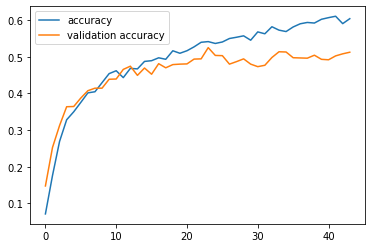

In [8]:
plt.plot(vgg16_history_callback.history["acc"])
plt.plot(vgg16_history_callback.history['val_acc'])
plt.legend(['accuracy', 'validation accuracy'])

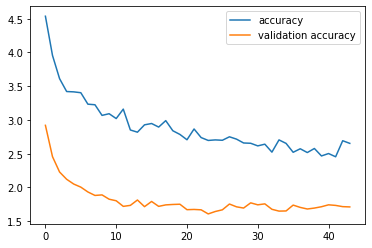

In [9]:
plt.plot(vgg16_history_callback.history["loss"])
plt.plot(vgg16_history_callback.history['val_loss'])
plt.legend(['accuracy', 'validation accuracy'])

In [10]:
score, acc = VGG.evaluate_generator(generator=validation_generator,
                       steps=Step_size_valid)
test_generator.reset()

pred = VGG.predict_generator(generator=test_generator,
                             steps=Step_size_test,
                             verbose=1)
predicted_class_indces = np.argmax(pred, axis=1)

777/777 [==============================] - 41s 52ms/step


In [11]:
labels = train_generator.class_indices
labels = dict((v, k) for k, v in labels.items())
predictions = [labels[k] for k in predicted_class_indces]

In [12]:
filenames = test_generator.filenames
results = pd.DataFrame({"Filename": filenames,
                        "Predictions": predictions})
results.to_csv("results.csv", index=False)

In [13]:
print("Test score ", score)
print("Test acc", acc)
results

Test score  1.6944713306427002
Test acc 0.51625


,Filename,Predictions
0,Abyssinian/Abyssinian_1.jpg,Abyssinian
1,Abyssinian/Abyssinian_10.jpg,Abyssinian
2,Abyssinian/Abyssinian_11.jpg,Abyssinian
3,Abyssinian/Abyssinian_12.jpg,Sphynx
4,Abyssinian/Abyssinian_13.jpg,Abyssinian
...,...,...
772,yorkshire_terrier/yorkshire_terrier_4.jpg,yorkshire_terrier
773,yorkshire_terrier/yorkshire_terrier_5.jpg,english_cocker_spaniel
774,yorkshire_terrier/yorkshire_terrier_6.jpg,beagle
775,yorkshire_terrier/yorkshire_terrier_7.jpg,leonberger
